In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [7]:
args = load_param('saved_models/kgc/all100/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.no_use_pe = False
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=False
args.pre_train=False
args.use_for_challenge090=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2023-01-22 03:49:16 - INFO - 2894379509.py - 15 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/all100/03/log.log', param_file='saved_models/kgc/all100/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/all100/03/checkpoint/', model_path='saved_models/kgc/all100/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=False, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge075=False, use_title=None, do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_token_s=4, embedding_dim=128, entity_embedding_dim=128, relation_emb

In [13]:
torch_fix_seed(seed=SEED)
return_dict = main_function(args, logger=logger)
model = return_dict['model']
load_model(model, args.model_path, device)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
print(return_dict.keys())
dataset_train, dataset_valid, dataset_test = return_dict['datasets']
triple = dataset_train.triple
data_helper = return_dict['data_helper']

entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

2023-01-22 03:51:11 - INFO - run_for_KGC.py - 820 - ----- make datahelper start. -----
2023-01-22 03:51:11 - INFO - data_helper.py - 331 - ====== Show MyRawData ======
2023-01-22 03:51:11 - INFO - data_helper.py - 332 - entity num: 7844
2023-01-22 03:51:11 - INFO - data_helper.py - 333 - relation num: 63
2023-01-22 03:51:11 - INFO - data_helper.py - 334 - ====== Show MyRawData ======
2023-01-22 03:51:11 - INFO - data_helper.py - 605 - ========== Show DataHelper ==========
2023-01-22 03:51:11 - INFO - data_helper.py - 331 - ====== Show MyRawData ======
2023-01-22 03:51:11 - INFO - data_helper.py - 332 - entity num: 7844
2023-01-22 03:51:11 - INFO - data_helper.py - 333 - relation num: 63
2023-01-22 03:51:11 - INFO - data_helper.py - 334 - ====== Show MyRawData ======
2023-01-22 03:51:11 - INFO - data_helper.py - 607 - entity_special_dicts: {0: '<pad_e>', 1: '<cls_e>', 2: '<mask_e>', 3: '<sep_e>', 4: '<bos_e>'}
2023-01-22 03:51:11 - INFO - data_helper.py - 608 - relation_special_dicts: {

dict_keys(['model', 'data_helper', 'datasets', 'data_loaders', 'train_returns'])


In [14]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [6]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [15]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [16]:
story_entities = triple_df['head'].tolist()

In [25]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['<bos_e>'],d_r['<bos_r>'],d_e['<bos_e>']],
            [d_e['<mask_e>'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['<mask_e>'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['<mask_e>'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['<mask_e>'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['<mask_e>'],d_r['kgc:why'],d_e[_why]],
            [d_e['<mask_e>'],d_r['kgc:what'],d_e[_what]],
            [d_e['<mask_e>'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [22]:
MASK_E = '<mask_e>'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [23]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

In [34]:
list(d_r.keys())[: 10]

['<pad_r>',
 '<cls_r>',
 '<mask_r>',
 '<sep_r>',
 '<bos_r>',
 'rdf:type',
 'kgc:subject',
 'kgc:ActionOption',
 'kgc:Not',
 'kgc:RelationBetweenScene']

### まだらの紐
Who killed Julia? (criminal & explanation)
被害者: Julia
犯人: Roylott
犯行に用いたもの: snake
犯行動機: 母の相続財産を独占したい

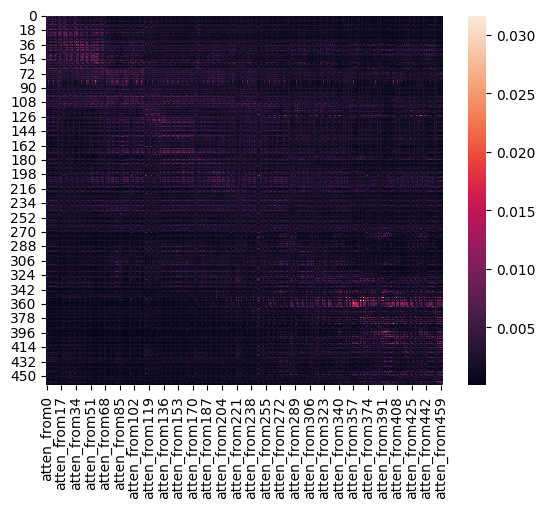

SpeckledBand:Roylott, ranking [4163]


,predicate,whom,subject,why,what,where
0,word.predicate:gangUp,SpeckledBand:housekeeper,SpeckledBand:sister,SpeckledBand:London,SpeckledBand:London,SpeckledBand:scar
1,word.predicate:swear,AbbeyGrange:Theresa,SpeckledBand:housekeeper,SpeckledBand:scar,SpeckledBand:by_hitting,SpeckledBand:London
2,word.predicate:love,SpeckledBand:sister,AbbeyGrange:Theresa,SpeckledBand:window_of_Julia_s_bedroom,SilverBlaze:Owner,SpeckledBand:window_of_Julia_s_bedroom
3,word.predicate:chill,SpeckledBand:man,SpeckledBand:man,SilverBlaze:Owner,SpeckledBand:scar,SpeckledBand:sister
4,SpeckledBand:the_day_Julia_died,SpeckledBand:1883-04-01T15,word.predicate:Ring,DateTime:1883-04-01T23:00:00,SpeckledBand:sister,SilverBlaze:Owner
5,word.predicate:stuck,SpeckledBand:scar,SilverBlaze:Subordinates_of_Silas_Brown,DateTime:1883-04-01T15:00:00,AbbeyGrange:Theresa,AbbeyGrange:Theresa
6,word.predicate:close,CrookedMan:Monday,SilverBlaze:Owner,SpeckledBand:man,SpeckledBand:Danger,AbbeyGrange:acrobat
7,word.predicate:sympathy,AbbeyGrange:acrobat,CrookedMan:Monday,word.predicate:scratch,SpeckledBand:man,SpeckledBand:8_years_ago
8,word.predicate:escape,SilverBlaze:Owner,SpeckledBand:coroner,SpeckledBand:by_hitting,SpeckledBand:housekeeper,SpeckledBand:Case
9,word.predicate:meeting,SpeckledBand:Danger,SpeckledBand:scar,AbbeyGrange:Theresa,SpeckledBand:1883-04-01T15,SpeckledBand:match_box


442

['SpeckledBand:399', 'kgc:to', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from442
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.011079
42,SpeckledBand:328,kgc:when,SpeckledBand:1883-04-02T03,0.009474
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.008895
36,SpeckledBand:327,kgc:when,SpeckledBand:1883-04-02T03,0.008747
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008262
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008179
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008101
48,SpeckledBand:329,kgc:when,SpeckledBand:1883-04-02T03,0.008000
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.007994
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.007664


----------


443

['SpeckledBand:399', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from443
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.010766
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.010581
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.008400
398,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.007304
444,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.007027
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.006915
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006891
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.006629
448,SpeckledBand:400,kgc:what,SpeckledBand:Roylott,0.006452
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.005912


----------


444

['SpeckledBand:399', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from444
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.014317
284,SpeckledBand:370,kgc:to,SpeckledBand:Julia_s_bedroom,0.009020
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.008740
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.008000
333,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.007755
338,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.007399
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.007391
179,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007253
219,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.006870
326,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.006826


----------


445

['<bos_e>', '<bos_r>', '<bos_e>']

,head,relation,tail,atten_from445
50,<bos_e>,<bos_r>,<bos_e>,0.004644
55,<bos_e>,<bos_r>,<bos_e>,0.004525
102,<bos_e>,<bos_r>,<bos_e>,0.004430
263,<bos_e>,<bos_r>,<bos_e>,0.004423
44,<bos_e>,<bos_r>,<bos_e>,0.004419
406,<bos_e>,<bos_r>,<bos_e>,0.004339
74,<bos_e>,<bos_r>,<bos_e>,0.004213
355,<bos_e>,<bos_r>,<bos_e>,0.004171
108,<bos_e>,<bos_r>,<bos_e>,0.004170
61,<bos_e>,<bos_r>,<bos_e>,0.004156


----------


446

['SpeckledBand:400', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from446
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.012888
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.012235
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.012217
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.011701
403,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.010409
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.009454
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.009385
362,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.009332
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.009231
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008365


----------


447

['SpeckledBand:400', 'kgc:hasPredicate', 'word.predicate:bite']

,head,relation,tail,atten_from447
384,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.011116
421,SpeckledBand:395,kgc:time,DateTime:1883-04-01T23:00:00,0.010167
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.008733
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008685
425,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.008565
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.008562
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008095
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.007898
35,SpeckledBand:327,kgc:what,SpeckledBand:whistle,0.007741
338,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.007721


----------


448

['SpeckledBand:400', 'kgc:what', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from448
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.015093
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.009917
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.009238
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.008999
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.008952
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.008777
37,SpeckledBand:327,kgc:time,DateTime:1883-04-02T03:00:00,0.008521
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.008505
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.008169
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.007508


----------


449

['SpeckledBand:400', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from449
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.012606
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.011642
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.009004
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008109
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007483
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.007043
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.006889
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.006855
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.006786
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.006393


----------


450

['SpeckledBand:400', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from450
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.015735
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.011977
333,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.011131
338,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010626
326,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009175
37,SpeckledBand:327,kgc:time,DateTime:1883-04-02T03:00:00,0.008981
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.008289
66,SpeckledBand:332,kgc:time,DateTime:1883-04-02T03:00:00,0.008171
311,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.008070
219,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.007822


----------


451

['<bos_e>', '<bos_r>', '<bos_e>']

,head,relation,tail,atten_from451
50,<bos_e>,<bos_r>,<bos_e>,0.004647
55,<bos_e>,<bos_r>,<bos_e>,0.004529
102,<bos_e>,<bos_r>,<bos_e>,0.004455
44,<bos_e>,<bos_r>,<bos_e>,0.004440
263,<bos_e>,<bos_r>,<bos_e>,0.004429
406,<bos_e>,<bos_r>,<bos_e>,0.004332
74,<bos_e>,<bos_r>,<bos_e>,0.004243
108,<bos_e>,<bos_r>,<bos_e>,0.004187
355,<bos_e>,<bos_r>,<bos_e>,0.004175
61,<bos_e>,<bos_r>,<bos_e>,0.004160


----------


452

['SpeckledBand:401', 'kgc:subject', 'SpeckledBand:Roma']

,head,relation,tail,atten_from452
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.018383
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.011362
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008609
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008215
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.008062
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.008055
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.007905
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.007450
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007319
410,SpeckledBand:393,kgc:when,SpeckledBand:069,0.007137


----------


453

['SpeckledBand:401', 'kgc:hasProperty', 'word.predicate:band']

,head,relation,tail,atten_from453
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.014268
365,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.009458
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.009233
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008984
457,<mask_e>,kgc:whom,SpeckledBand:Julia,0.008378
371,SpeckledBand:385,kgc:to,SpeckledBand:bed,0.008338
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.008206
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008024
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007945
375,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007848


----------


454

['<bos_e>', '<bos_r>', '<bos_e>']

,head,relation,tail,atten_from454
50,<bos_e>,<bos_r>,<bos_e>,0.004559
55,<bos_e>,<bos_r>,<bos_e>,0.004443
102,<bos_e>,<bos_r>,<bos_e>,0.004400
44,<bos_e>,<bos_r>,<bos_e>,0.004379
263,<bos_e>,<bos_r>,<bos_e>,0.004332
406,<bos_e>,<bos_r>,<bos_e>,0.004230
74,<bos_e>,<bos_r>,<bos_e>,0.004188
108,<bos_e>,<bos_r>,<bos_e>,0.004123
61,<bos_e>,<bos_r>,<bos_e>,0.004111
355,<bos_e>,<bos_r>,<bos_e>,0.004097


----------


455

['<mask_e>', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from455
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.016056
403,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.014157
457,<mask_e>,kgc:whom,SpeckledBand:Julia,0.013837
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.013653
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.013481
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013108
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.011303
412,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.011123
384,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.010638
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.010431


----------


456

['<mask_e>', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from456
384,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.012863
124,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.009151
457,<mask_e>,kgc:whom,SpeckledBand:Julia,0.008700
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.007888
237,SpeckledBand:362,kgc:time,DateTime:1883-04-02T04:00:00,0.007322
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.007043
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006998
379,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.006948
432,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.006886
240,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.006735


----------


457

['<mask_e>', 'kgc:whom', 'SpeckledBand:Julia']

,head,relation,tail,atten_from457
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.014014
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013279
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.012189
403,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.010835
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.010748
457,<mask_e>,kgc:whom,SpeckledBand:Julia,0.010620
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.009968
448,SpeckledBand:400,kgc:what,SpeckledBand:Roylott,0.009244
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.008951
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.008170


----------


458

['<mask_e>', 'kgc:subject', '<mask_e>']

,head,relation,tail,atten_from458
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.017507
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.017401
403,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.016031
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013599
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.013400
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.011749
457,<mask_e>,kgc:whom,SpeckledBand:Julia,0.011409
407,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.010370
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.009975
412,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.009032


----------


459

['<mask_e>', 'kgc:why', '<mask_e>']

,head,relation,tail,atten_from459
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.014401
432,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.014048
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.013915
460,<mask_e>,kgc:what,<mask_e>,0.013251
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.012972
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.012532
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.011667
410,SpeckledBand:393,kgc:when,SpeckledBand:069,0.010925
444,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.010572
311,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.010337


----------


460

['<mask_e>', 'kgc:what', '<mask_e>']

,head,relation,tail,atten_from460
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.022350
410,SpeckledBand:393,kgc:when,SpeckledBand:069,0.014577
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.012984
425,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.010776
403,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.010428
460,<mask_e>,kgc:what,<mask_e>,0.009674
427,SpeckledBand:396,kgc:time,DateTime:1883-04-01T23:00:00,0.009097
407,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.008891
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.008667
457,<mask_e>,kgc:whom,SpeckledBand:Julia,0.008467


----------


461

['<mask_e>', 'kgc:where', '<mask_e>']

,head,relation,tail,atten_from461
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.031420
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.014623
460,<mask_e>,kgc:what,<mask_e>,0.013494
410,SpeckledBand:393,kgc:when,SpeckledBand:069,0.013231
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.012873
384,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.012460
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.012240
400,SpeckledBand:391,kgc:when,SpeckledBand:1881-04-02T00:30,0.012157
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010306
403,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.010267


----------


In [26]:
title = 'SpeckledBand'
victim_name = 'Julia'
killer_name = 'Roylott'
last_index = 401
story_len = 80

df_ranking_SpeckledBand, df_attension_SpeckledBand = main_func01(title, victim_name, killer_name, last_index, story_len)

In [ ]:
d_e['']

### 悪魔の足跡１
Who killed the victims? (criminal & explanation)
被害者: Brenda
犯人: Mortimer
犯行動機: 財産

In [ ]:
title = 'DevilsFoot'
victim_name = 'Brenda'
killer_name = 'Mortimer'
last_index = 489
story_len = 80
df_ranking_DevilsFoot1, df_attension_DevilsFoot1 = main_func01(title, victim_name, killer_name, last_index, story_len)

### 悪魔の足跡2
Who killed the victims? (criminal & explanation)
被害者: Mortimer
犯人: 
犯行動機: 恋人の敵

In [ ]:
title = 'DevilsFoot'
victim_name = 'Mortimer'
killer_name = 'Sterndale'
last_index = 489
story_len = 80
df_ranking_DevilsFoot2, df_attension_DevilsFoot2 = main_func01(title, victim_name, killer_name, last_index, story_len)

### 背中の曲がった男: 
Why did Barclay die?
被害者: Barclay
犯人: 
犯行動機: 

In [ ]:
victim = 'CrookedMan:Barclay'
df_ranking_CrookedMan, df_attension_CrookedMan = make_ranking(
    f'CrookedMan:{373-80+1}', 'CrookedMan:373', DIE, MASK_E, victim, MASK_E, MASK_E, MASK_E)

display(df_ranking_CrookedMan.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_CrookedMan)
for i in range(len_-20, len_):
    display(i, df_attension_CrookedMan.iloc[i,:3].tolist())
    display(df_attension_CrookedMan.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 僧坊荘園
Who killed Lord Blackenstall? (criminal & explanation)
被害者: Sir_Eustace_Brackenstall
犯人: 
犯行動機: 

In [ ]:
title = 'AbbeyGrange'
victim_name = 'Sir_Eustace_Brackenstall'
killer_name = 'Jack_Croker'
last_index = 414
story_len = 80

df_ranking_AbbeyGrange, df_attension_AbbeyGrange = main_func01(title, victim_name, killer_name, last_index, story_len)

### 入院患者
Who killed Blessington? (criminal & explanation)
被害者: Blessington
犯人: 3人
犯行動機: 

In [ ]:
title = 'ResidentPatient'
victim_name = 'Blessington'
killer_name = ''
last_index = 324
story_len = 80

df_ranking_Blessington, df_attension_Blessington = main_func01(title, victim_name, killer_name, last_index, story_len)

### 白銀
Who took out the White Silver Blaze? (criminal & explanation) 
被害者: Silver_Blaze
犯人: 
犯行動機: 

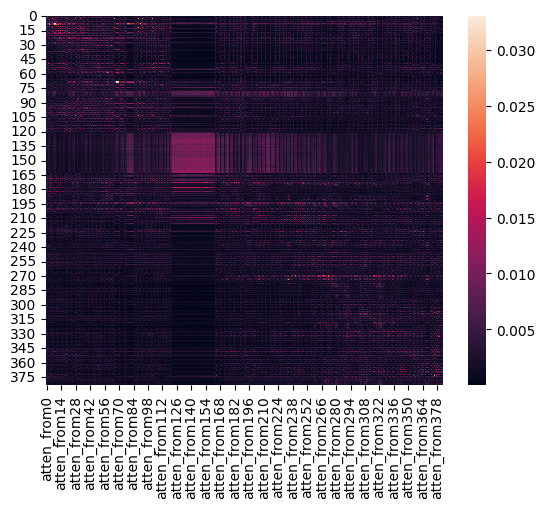

,predicate,whom,subject,why,what,where
0,word.predicate:have,SilverBlaze:Silver_Blaze,SilverBlaze:Silver_Blaze,SpeckledBand:mansion_of_Roylott,SilverBlaze:Silver_Blaze,SilverBlaze:John_Straker
1,SilverBlaze:Night_of_the_incident,SilverBlaze:Fitzroy_Simpson,SilverBlaze:John_Straker,SpeckledBand:bed,SilverBlaze:John_Straker,AllTitle:Holmes
2,word.predicate:say,SilverBlaze:John_Straker,SilverBlaze:Fitzroy_Simpson,SpeckledBand:Julia_s_bedroom,AllTitle:Holmes,SpeckledBand:Julia_s_bedroom
3,word.predicate:find,AllTitle:Holmes,AllTitle:Holmes,AllTitle:Holmes,SilverBlaze:Fitzroy_Simpson,DateTime:1881-04-01T00:00:00
4,word.predicate:ask,AllTitle:Watson,AllTitle:Watson,SilverBlaze:Colonel_Ross,AllTitle:Watson,SilverBlaze:Silver_Blaze
5,word.predicate:go,ACaseOfIdentity:Hosmer,SilverBlaze:Silas_Brown,word.predicate:escape,ACaseOfIdentity:Hosmer,SpeckledBand:Roylott
6,word.predicate:try,AbbeyGrange:Lady_Brackenstall,CrookedMan:Barclay,AllTitle:Watson,CrookedMan:Barclay,SilverBlaze:Colonel_Ross
7,word.predicate:exist,SilverBlaze:Ned_Hunter,SilverBlaze:Gregory_Inspector,ResidentPatient:Helper_boy,SpeckledBand:Julia_s_bedroom,ResidentPatient:Blessington
8,word.predicate:examine,SilverBlaze:Silas_Brown,SilverBlaze:Ned_Hunter,SilverBlaze:John_Straker,AbbeyGrange:Lady_Brackenstall,SilverBlaze:stable
9,word.predicate:get,DevilsFoot:Brenda,AbbeyGrange:Lady_Brackenstall,word.predicate:louder,DancingMen:Cubitt,SpeckledBand:corridor


364

['SilverBlaze:394', 'kgc:hasPredicate', 'word.predicate:buy']

,head,relation,tail,atten_from364
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.014575
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.011584
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.010953
246,SilverBlaze:371a,kgc:what,SilverBlaze:Silver_Blaze,0.010089
254,SilverBlaze:373,kgc:what,SilverBlaze:Injustice,0.009790
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.009703
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.008748
250,SilverBlaze:372,kgc:what,SilverBlaze:Lame,0.008588
314,SilverBlaze:385,kgc:what,SilverBlaze:legs_of_Silver_Blaze,0.007880
53,SilverBlaze:341,kgc:subject,SilverBlaze:Colonel_Ross,0.007818


----------


365

['SilverBlaze:394', 'kgc:what', 'SilverBlaze:Expensive_clothes']

,head,relation,tail,atten_from365
224,SilverBlaze:366,kgc:what,SilverBlaze:Lot_of_money,0.019052
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.014648
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.013110
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.012521
53,SilverBlaze:341,kgc:subject,SilverBlaze:Colonel_Ross,0.009331
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.009312
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.008762
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.008176
222,SilverBlaze:366,kgc:subject,SilverBlaze:horse_trainer,0.007835
228,SilverBlaze:367,kgc:what,SilverBlaze:Horse,0.007682


----------


366

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from366
42,SilverBlaze:338,kgc:hasPredicate,word.predicate:exist,0.006342
23,SilverBlaze:333,kgc:to,SilverBlaze:Youth_stables_number,0.005736
75,bos_e,bos_r,bos_e,0.005348
8,SilverBlaze:331,kgc:what,SilverBlaze:331a,0.005217
85,bos_e,bos_r,bos_e,0.005137
29,bos_e,bos_r,bos_e,0.005089
56,bos_e,bos_r,bos_e,0.005055
0,bos_e,bos_r,bos_e,0.004938
24,bos_e,bos_r,bos_e,0.004912
70,bos_e,bos_r,bos_e,0.004907


----------


367

['SilverBlaze:395', 'kgc:subject', 'SilverBlaze:John_Straker']

,head,relation,tail,atten_from367
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.015337
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.014397
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.011748
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.011647
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.011270
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010597
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.010405
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.009857
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.009321
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.008304


----------


368

['SilverBlaze:395', 'kgc:hasPredicate', 'word.predicate:have']

,head,relation,tail,atten_from368
274,SilverBlaze:377,kgc:hasProperty,word.predicate:dark,0.016944
190,SilverBlaze:359b,kgc:hasProperty,word.predicate:Curry_dish,0.013793
187,SilverBlaze:359a,kgc:hasProperty,SilverBlaze:359b,0.013142
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.011912
31,SilverBlaze:335,kgc:hasProperty,word.predicate:lame,0.011335
238,SilverBlaze:370,kgc:hasProperty,word.predicate:wacky,0.011241
344,SilverBlaze:390a,kgc:what,SilverBlaze:thigh_of_John_Straker,0.010161
337,SilverBlaze:389,kgc:what,SilverBlaze:The_forehead_of_John_Straker,0.010060
269,SilverBlaze:376,kgc:what,SilverBlaze:candle,0.010041
235,SilverBlaze:369,kgc:what,SilverBlaze:knife,0.008965


----------


369

['SilverBlaze:395', 'kgc:what', 'SilverBlaze:debt']

,head,relation,tail,atten_from369
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.009276
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.009080
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.008624
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.008153
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.007864
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.007699
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.007389
357,SilverBlaze:393,kgc:what,SilverBlaze:the_hat_decoration_shop,0.007147
194,SilverBlaze:360,kgc:what,SilverBlaze:John_Straker,0.006855
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.006574


----------


370

['SilverBlaze:395', 'kgc:why', 'SilverBlaze:394']

,head,relation,tail,atten_from370
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.009316
100,SilverBlaze:348a,kgc:to,SilverBlaze:Horseracing,0.006814
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.006530
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.006339
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.006055
250,SilverBlaze:372,kgc:what,SilverBlaze:Lame,0.005971
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.005858
98,SilverBlaze:348a,kgc:subject,SilverBlaze:Silver_Blaze,0.005810
246,SilverBlaze:371a,kgc:what,SilverBlaze:Silver_Blaze,0.005702
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.005674


----------


371

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from371
8,SilverBlaze:331,kgc:what,SilverBlaze:331a,0.005822
23,SilverBlaze:333,kgc:to,SilverBlaze:Youth_stables_number,0.005690
42,SilverBlaze:338,kgc:hasPredicate,word.predicate:exist,0.005676
75,bos_e,bos_r,bos_e,0.005191
85,bos_e,bos_r,bos_e,0.004991
29,bos_e,bos_r,bos_e,0.004908
56,bos_e,bos_r,bos_e,0.004901
0,bos_e,bos_r,bos_e,0.004796
24,bos_e,bos_r,bos_e,0.004764
70,bos_e,bos_r,bos_e,0.004742


----------


372

['SilverBlaze:396', 'kgc:subject', 'SilverBlaze:Colonel_Ross']

,head,relation,tail,atten_from372
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.017832
351,SilverBlaze:392,kgc:subject,SilverBlaze:John_Straker,0.015255
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.014331
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.014249
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.011662
346,SilverBlaze:391,kgc:subject,SilverBlaze:John_Straker,0.010835
312,SilverBlaze:385,kgc:subject,SilverBlaze:John_Straker,0.010788
53,SilverBlaze:341,kgc:subject,SilverBlaze:Colonel_Ross,0.010689
252,SilverBlaze:373,kgc:subject,SilverBlaze:People,0.010213
303,SilverBlaze:383a,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.010033


----------


373

['SilverBlaze:396', 'kgc:hasPredicate', 'word.predicate:ask']

,head,relation,tail,atten_from373
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.008945
344,SilverBlaze:390a,kgc:what,SilverBlaze:thigh_of_John_Straker,0.008900
254,SilverBlaze:373,kgc:what,SilverBlaze:Injustice,0.008498
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.007707
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.007485
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.007214
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.007024
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.006912
51,SilverBlaze:340,kgc:on,SilverBlaze:Brown_horse,0.006709
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.006674


----------


374

['SilverBlaze:396', 'kgc:what', 'SilverBlaze:Place_of_the_horse']

,head,relation,tail,atten_from374
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.014151
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.010376
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.008752
161,SilverBlaze:354,kgc:what,SilverBlaze:394,0.008676
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.008308
215,SilverBlaze:364,kgc:what,SilverBlaze:Dog_of_the_stables,0.008168
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.008054
153,SilverBlaze:354,kgc:what,SilverBlaze:386,0.008022
135,SilverBlaze:354,kgc:what,SilverBlaze:368,0.008000
151,SilverBlaze:354,kgc:what,SilverBlaze:384,0.007932


----------


375

['SilverBlaze:396', 'kgc:to', 'AllTitle:Holmes']

,head,relation,tail,atten_from375
373,SilverBlaze:396,kgc:hasPredicate,word.predicate:ask,0.026520
352,SilverBlaze:392,kgc:hasPredicate,word.predicate:practice,0.019100
308,SilverBlaze:384,kgc:hasPredicate,word.predicate:pick,0.018093
193,SilverBlaze:360,kgc:hasPredicate,word.predicate:suspect,0.013524
347,SilverBlaze:391,kgc:hasPredicate,word.predicate:takeOff,0.011626
356,SilverBlaze:393,kgc:hasPredicate,word.predicate:go,0.011223
364,SilverBlaze:394,kgc:hasPredicate,word.predicate:buy,0.011193
103,SilverBlaze:349,kgc:hasPredicate,word.predicate:catch,0.011088
360,SilverBlaze:393a,kgc:hasPredicate,word.predicate:confirm,0.010392
223,SilverBlaze:366,kgc:hasPredicate,word.predicate:get,0.009754


----------


376

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from376
8,SilverBlaze:331,kgc:what,SilverBlaze:331a,0.005739
23,SilverBlaze:333,kgc:to,SilverBlaze:Youth_stables_number,0.005704
42,SilverBlaze:338,kgc:hasPredicate,word.predicate:exist,0.005367
75,bos_e,bos_r,bos_e,0.005252
85,bos_e,bos_r,bos_e,0.005039
29,bos_e,bos_r,bos_e,0.004998
56,bos_e,bos_r,bos_e,0.004986
0,bos_e,bos_r,bos_e,0.004870
24,bos_e,bos_r,bos_e,0.004864
70,bos_e,bos_r,bos_e,0.004863


----------


377

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from377
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.014056
351,SilverBlaze:392,kgc:subject,SilverBlaze:John_Straker,0.013245
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.011891
346,SilverBlaze:391,kgc:subject,SilverBlaze:John_Straker,0.010760
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.010337
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010254
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.009763
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.009464
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.009124
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.008249


----------


378

['mask_e', 'kgc:hasPredicate', 'word.predicate:bring']

,head,relation,tail,atten_from378
344,SilverBlaze:390a,kgc:what,SilverBlaze:thigh_of_John_Straker,0.013948
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.013810
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.013415
314,SilverBlaze:385,kgc:what,SilverBlaze:legs_of_Silver_Blaze,0.012739
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.012346
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.011409
269,SilverBlaze:376,kgc:what,SilverBlaze:candle,0.010751
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.010702
337,SilverBlaze:389,kgc:what,SilverBlaze:The_forehead_of_John_Straker,0.010516
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.010508


----------


379

['mask_e', 'kgc:whom', 'mask_e']

,head,relation,tail,atten_from379
333,SilverBlaze:388,kgc:when,SilverBlaze:387,0.021062
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.015080
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010405
326,SilverBlaze:387a,kgc:subject,SilverBlaze:Silver_Blaze,0.009876
330,SilverBlaze:388,kgc:subject,SilverBlaze:John_Straker,0.009211
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.008174
312,SilverBlaze:385,kgc:subject,SilverBlaze:John_Straker,0.008088
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.007924
303,SilverBlaze:383a,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.007587
321,SilverBlaze:387,kgc:subject,SilverBlaze:Silver_Blaze,0.007361


----------


380

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from380
333,SilverBlaze:388,kgc:when,SilverBlaze:387,0.015483
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.013277
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.012219
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010644
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.009703
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.009697
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.009206
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.009035
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.008144
351,SilverBlaze:392,kgc:subject,SilverBlaze:John_Straker,0.008122


----------


381

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from381
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.007931
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.007328
235,SilverBlaze:369,kgc:what,SilverBlaze:knife,0.007225
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.007006
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.006932
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.006799
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.006748
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.006442
100,SilverBlaze:348a,kgc:to,SilverBlaze:Horseracing,0.006386
160,SilverBlaze:354,kgc:what,SilverBlaze:393,0.006373


----------


382

['mask_e', 'kgc:what', 'SilverBlaze:Silver_Blaze']

,head,relation,tail,atten_from382
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.013675
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.012921
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.011427
224,SilverBlaze:366,kgc:what,SilverBlaze:Lot_of_money,0.010027
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.010017
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.009632
228,SilverBlaze:367,kgc:what,SilverBlaze:Horse,0.009522
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.008574
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.008262
235,SilverBlaze:369,kgc:what,SilverBlaze:knife,0.007805


----------


383

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from383
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.008949
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.008379
224,SilverBlaze:366,kgc:what,SilverBlaze:Lot_of_money,0.008349
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.008093
55,SilverBlaze:341,kgc:what,SilverBlaze:342,0.007215
321,SilverBlaze:387,kgc:subject,SilverBlaze:Silver_Blaze,0.007094
228,SilverBlaze:367,kgc:what,SilverBlaze:Horse,0.007058
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.006979
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.006852
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.006800


----------


In [12]:
victim = 'SilverBlaze:Silver_Blaze'
df_ranking_SilverBlaze, df_attension_SilverBlaze = make_ranking(
    'SilverBlaze:330', 'SilverBlaze:396', BRING, MASK_E, MASK_E, MASK_E, victim, MASK_E)

display(df_ranking_SilverBlaze.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_SilverBlaze)
for i in range(len_-20, len_):
    display(i, df_attension_SilverBlaze.iloc[i,:3].tolist())
    display(df_attension_SilverBlaze.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 花嫁失踪事件（同一事件）
hozmaの失踪の名瀬を探る
被害者: ACaseOfIdentity:Hozma
犯人: 
犯行動機: 

In [ ]:
victim = 'ACaseOfIdentity:Hosmer'
df_ranking_ACaseOfIdentity, df_attension_ACaseOfIdentity = make_ranking(
    'ACaseOfIdentity:510', 'ACaseOfIdentity:578', HIDE, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_ACaseOfIdentity.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_ACaseOfIdentity)
for i in range(len_-20, len_):
    display(i, df_attension_ACaseOfIdentity.iloc[i,:3].tolist())
    display(df_attension_ACaseOfIdentity.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")
